In [115]:
import os
from timeit import default_timer as timer
import pandas as pd
from datetime import datetime, timedelta
from glob import glob
from pathlib import Path
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

In [46]:
start_date='01/01/2020'
end_date='04/16/2020'
source='cuebiq'
country='ID'
admin_id='ADM4_PCODE'
city_id='UC_NM_MN'
demographics=[
'median_age', 
'wealth_index',
'total_population',
]
path_to_data='/scratch/spf248/covid/data'

In [3]:
def get_coords(df):
    df['latitude']=df['point'].apply(lambda x:x['latitude'])
    df['longitude']=df['point'].apply(lambda x:x['longitude'])
    return df.drop('point',1)

In [4]:
print('Import parquet files')
start = timer()
data_dir = Path(os.path.join(path_to_data,source,'processed',country,'primary_home'))
primary_home = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)
print("Done in", round(timer()-start), "sec")  

Import parquet files
Done in 2 sec


In [5]:
print('Import admin data')
start = timer()
admin=gpd.read_file(os.path.join(path_to_data,'admin',country,'admin.geojson'))
admin2city=pd.read_excel(os.path.join(path_to_data,'admin',country,'city2adminGHSL.xlsx'))[[city_id,admin_id]].drop_duplicates(admin_id)
print("Done in", round(timer()-start), "sec")  

Import admin data
Done in 64 sec


In [ ]:
print('Turn primary home into GDF')
primary_home=get_coords(primary_home)
primary_home=gpd.GeoDataFrame(primary_home,geometry=gpd.points_from_xy(primary_home.longitude,primary_home.latitude))
primary_home.crs='epsg:4326'
print("Done in", round(timer()-start), "sec")  

In [88]:
print('Merge data')
start = timer()

geocoded_home=gpd.sjoin(admin[[admin_id,'geometry']],primary_home[['cuebiq_id','geometry']],op='intersects')
geocoded_home=admin[['ADM4_PCODE','ADM3_PCODE','total_population','a_km2','wealth_index','median_age','geometry']].merge(
geocoded_home.groupby('ADM4_PCODE')['cuebiq_id'].count().rename('n_users'),on='ADM4_PCODE',how='left')
geocoded_home=geocoded_home.merge(admin2city,how='left')

geocoded_home=geocoded_home.dissolve(
by='ADM3_PCODE',aggfunc={
city_id:'first',
'total_population':'sum',
'a_km2':'sum',
'wealth_index':'median',
'median_age':'median',
'n_users':'sum',})

geocoded_home['population_density']=geocoded_home.total_population.divide(geocoded_home.a_km2)
geocoded_home['penetration']=geocoded_home.n_users.divide(geocoded_home.total_population)*100
top_cities=admin2city.UC_NM_MN.value_counts().index[:5]

print("Done in", round(timer()-start), "sec")

Merge data
Done in 471 sec


# Penetration rates

/scratch/spf248/pyenv/py3.7/lib/python3.7/site-packages/mapclassify/classifiers.py:859: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
/scratch/spf248/pyenv/py3.7/lib/python3.7/site-packages/mapclassify/classifiers.py:890: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam
/scratch/spf248/pyenv/py3.7/lib/python3.7/site-packages/geopandas/plotting.py:335: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/scratch/spf248/pyenv/py3.7/lib/python3.7/site-packages/geopandas/plotting.py:335: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/scratch/spf248/pyenv/py3.7/lib/python3.7/site-packages/mapclassify/classifiers.py:859: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
/scratch/spf248/pyenv/py3.7/lib/python3.7/site-packages/mapclassify/classifiers.py:890: RuntimeWarning: invalid 

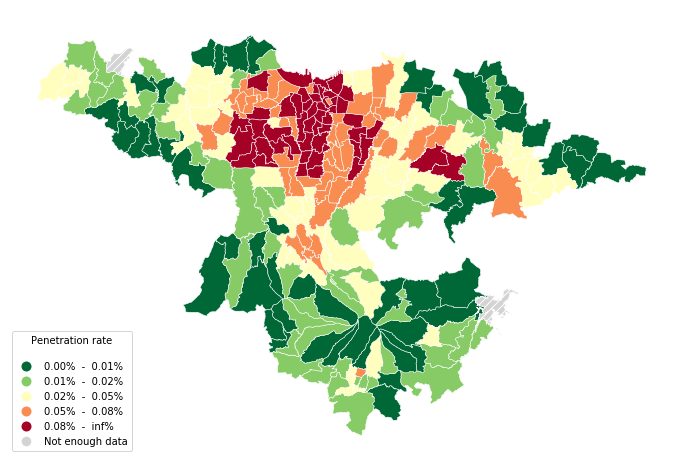

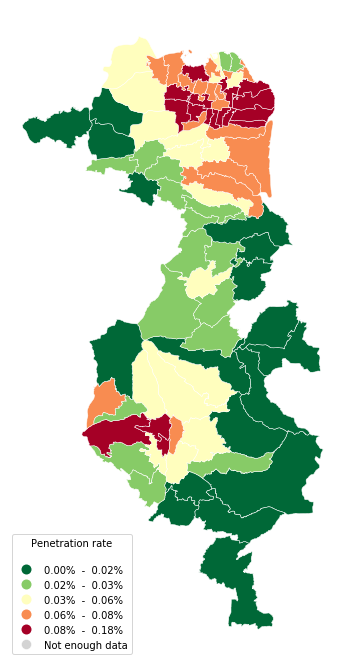

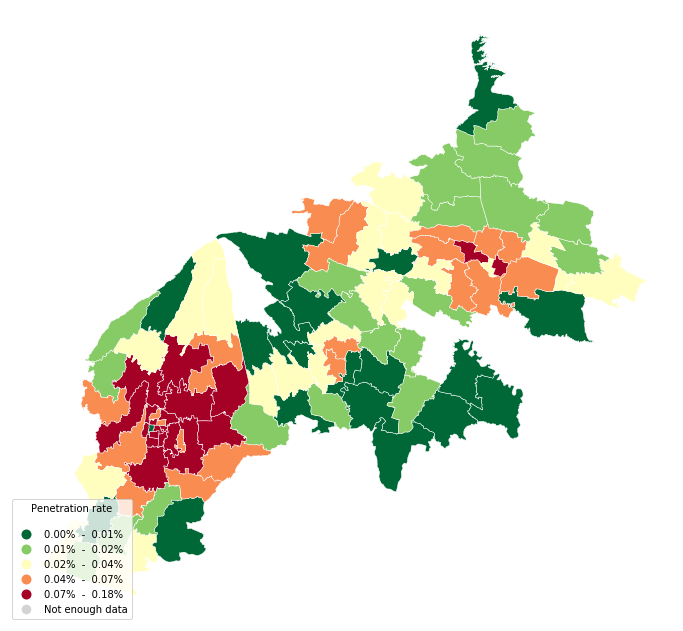

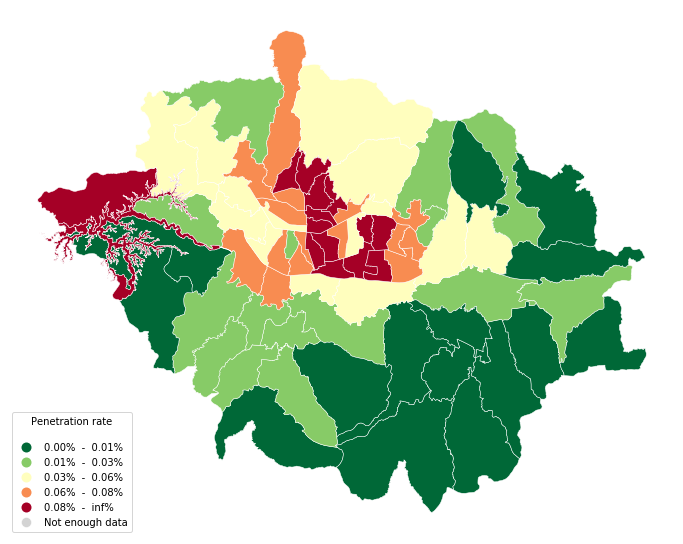

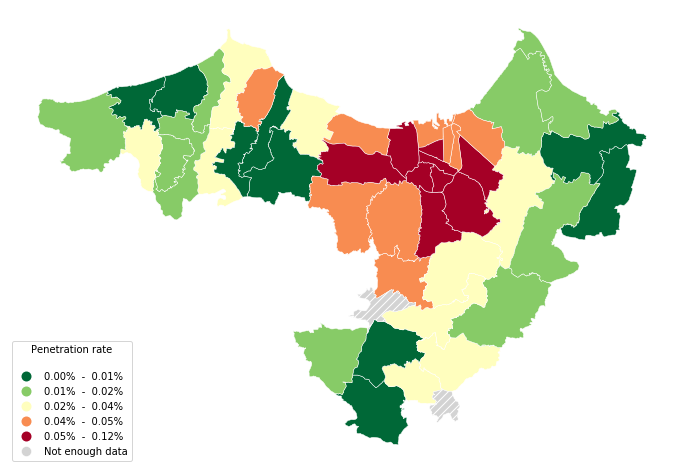

In [89]:
for city_name in top_cities:
    fig, ax = plt.subplots(1, figsize=(12, 12))
    plot = geocoded_home[geocoded_home.UC_NM_MN==city_name].plot(
    ax=ax,
    column='penetration', 
    edgecolor='white', 
    linewidth=0.5,
    legend=True, 
    cmap='RdYlGn_r', 
    scheme='quantiles',
    missing_kwds={"color": "lightgrey","hatch": "///","label": "Not enough data",},
    legend_kwds={'loc': 'lower left','title':'Penetration rate\n'})
    ax.axis('off')
    leg = plot.get_legend()
    for lbl in leg.get_texts()[:-1]:
        label_text = lbl.get_text()
        lower = label_text.split()[0]
        upper = label_text.split()[2]
        new_text = f'{float(lower):,.2f}%  -  {float(upper):,.2f}%'
        lbl.set_text(new_text)
    plt.savefig(os.path.join(path_to_data,'../fig/map-'+city_name+'.pdf'), bbox_inches='tight')

# Penetration bias

In [150]:
def penetration_bias(df,col,n_bins):
    fig,ax=plt.subplots(figsize=(8,6))
    data=df.groupby(pd.qcut(df[col],n_bins,range(1,n_bins+1)))['penetration'].agg(['mean','sem']).dropna()
    plt.errorbar(data.index, 'mean', data=data, linewidth=1, color='k')
    ax.fill_between(data.index,data['mean']-2*data['sem'],data['mean']+2*data['sem'],alpha=0.25,color='k')
    ax.tick_params(which='both',direction='in',pad=3)
    ax.set_ylabel('Share of users (% of total pop.)',fontweight='bold')
    ax.set_xlabel('Decile of '+col.replace('_',' '),fontweight='bold')
    ax.locator_params(axis='both',nbins=10)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals/100])
    plt.savefig(os.path.join(path_to_data+'/../fig',country,col.replace('_','-')+'-penetration-bias.pdf'),bbox_inches='tight')

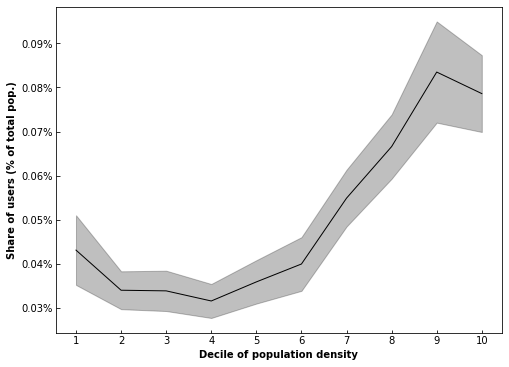

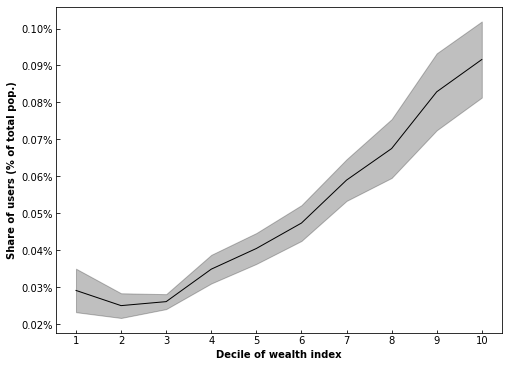

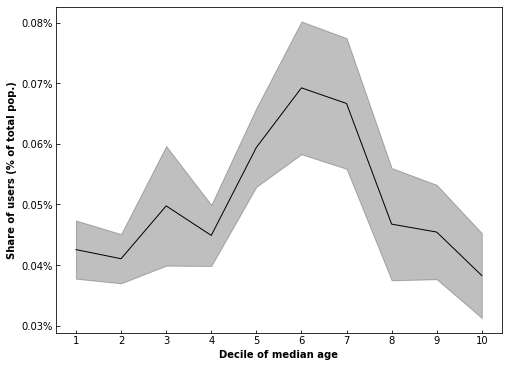

In [152]:
df=geocoded_home[geocoded_home.n_users>=10].replace([np.inf, -np.inf], np.nan).copy()
for col in ['population_density','wealth_index','median_age']:
    penetration_bias(df,col,n_bins=10)